In [1]:
from qiskit import __version__
print(__version__)

1.3.2


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit.quantum_info import Operator
from numpy import pi, random

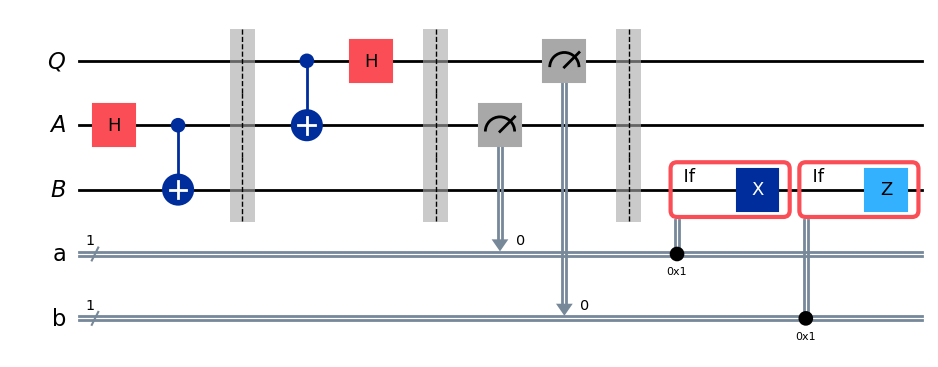

In [3]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output='mpl'))

In [4]:
random_gate = UGate(theta = random.random() * 2 * pi, phi = random.random() * 2 * pi, lam = random.random() * 2 * pi)
display(array_to_latex(random_gate.to_matrix()))

<IPython.core.display.Latex object>

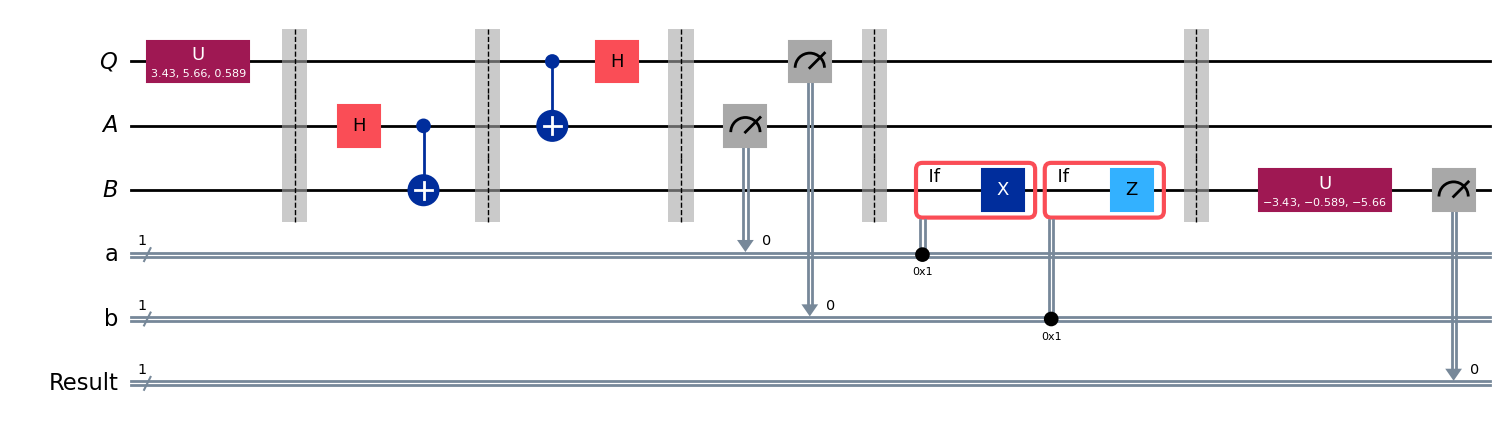

In [5]:
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)
test.append(random_gate, qubit)
test.barrier()

test = test.compose(protocol)
test.barrier()

test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw(output="mpl"))

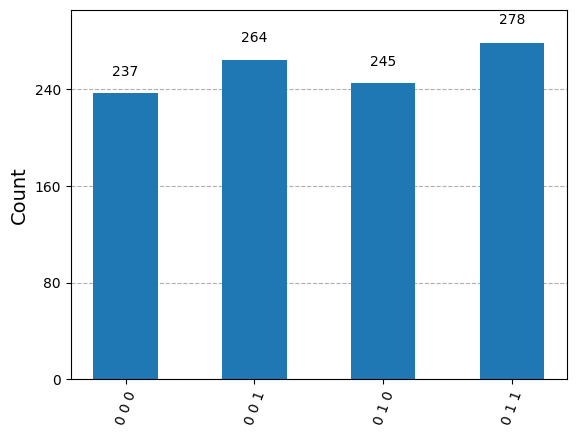

In [6]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

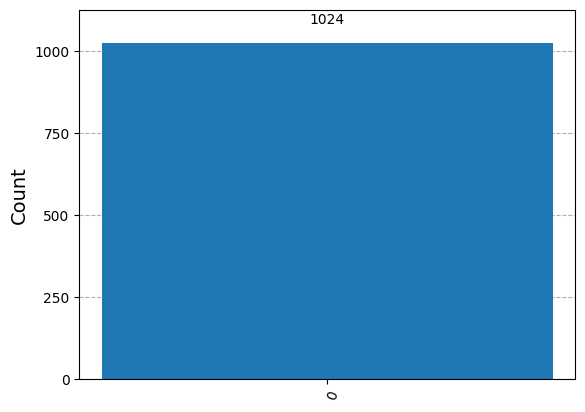

In [7]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

In [8]:
c = "1"
d = "0"

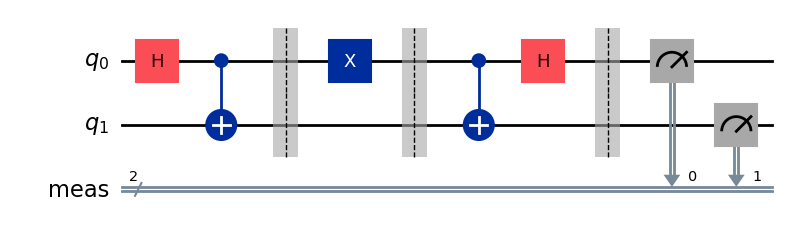

In [9]:
protocol = QuantumCircuit(2)

protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)

protocol.barrier()

protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw(output="mpl"))

Measured 10 with frequency 1024


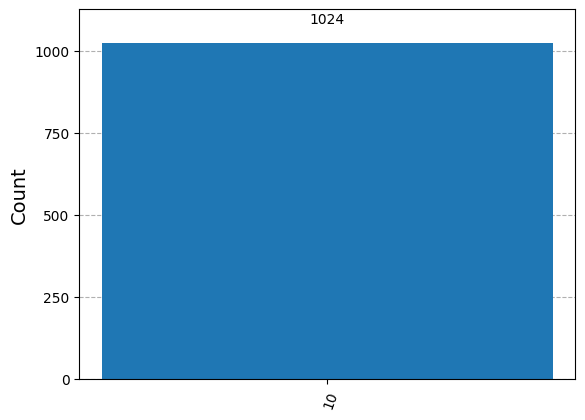

In [11]:
result = AerSimulator().run(protocol).result()
statistics = result.get_counts()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

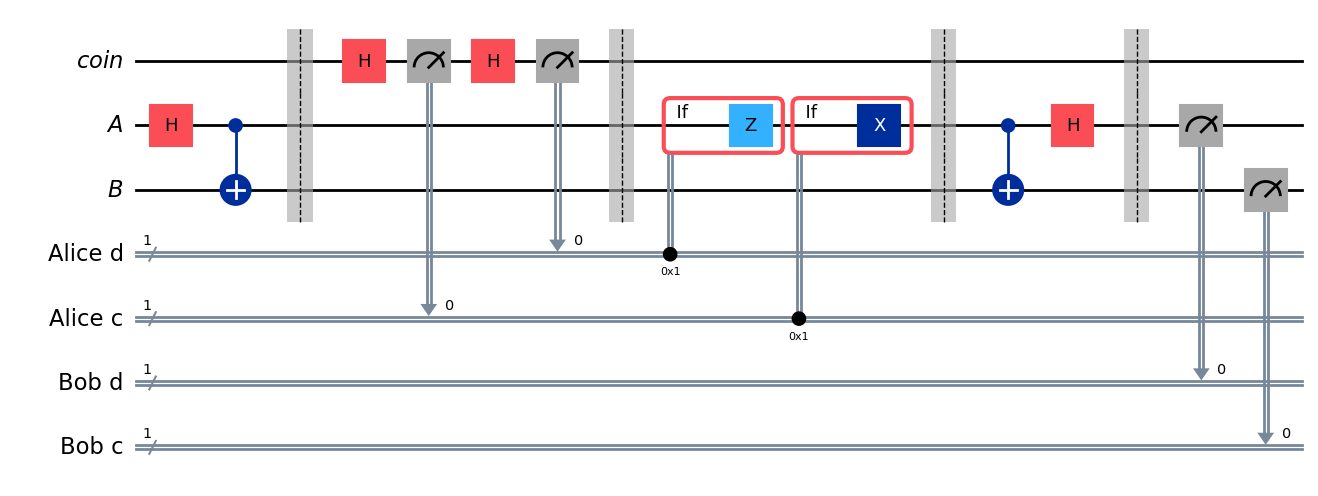

In [12]:
rbg = QuantumRegister(1, "coin")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw(output="mpl"))

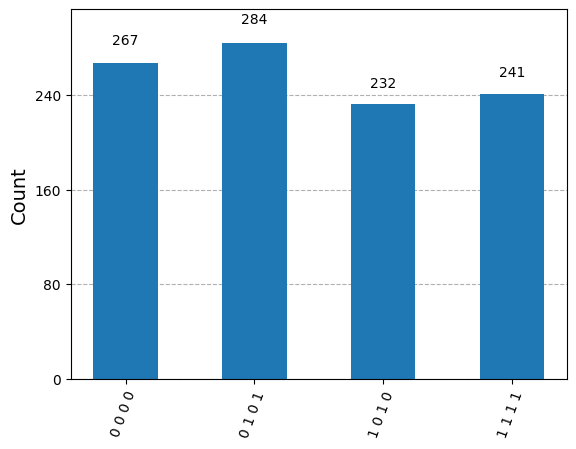

In [13]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

(x, y) = (0, 0)


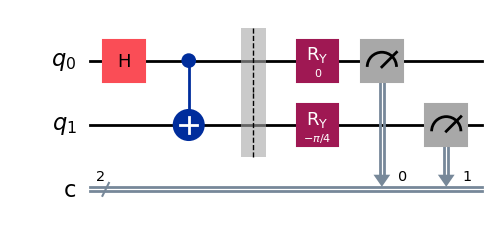

(x, y) = (0, 1)


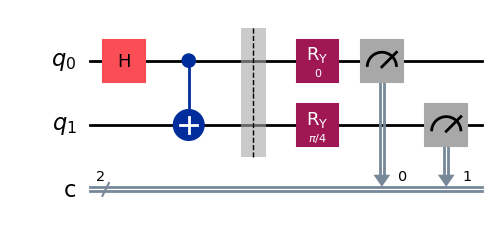

(x, y) = (1, 0)


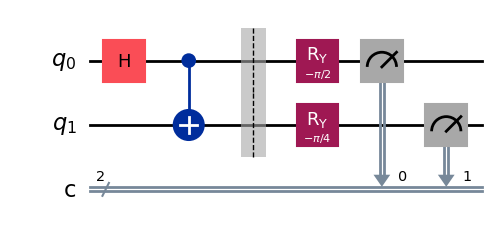

(x, y) = (1, 1)


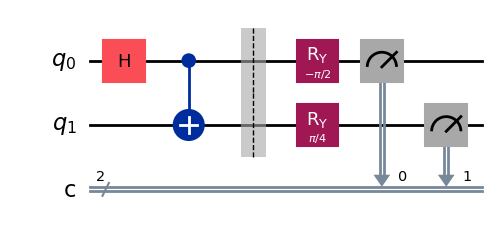

In [15]:
def chsh_game(strategy):
    x, y = random.randint(0, 2), random.randint(0, 2)
    a, b = strategy(x, y)

    if(a != b) == (x & y):
        return 1
    return 0

def chsh_circuit(x, y):
    qc = QuantumCircuit(2, 2)

    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

print("(x, y) = (0, 0)")
display(chsh_circuit(0, 0).draw(output="mpl"))

print("(x, y) = (0, 1)")
display(chsh_circuit(0, 1).draw(output="mpl"))

print("(x, y) = (1, 0)")
display(chsh_circuit(1, 0).draw(output="mpl"))

print("(x, y) = (1, 1)")
display(chsh_circuit(1, 1).draw(output="mpl"))
    

In [16]:
def quantum_strategy(x, y):
    result = AerSimulator().run(chsh_circuit(x, y), shots = 1).result()
    statistics = result.get_counts()

    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

In [17]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won : ", TOTAL_SCORE / NUM_GAMES)

Fraction of games won :  0.85


In [18]:
def classical_strategy(x, y):
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

In [19]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won : ", TOTAL_SCORE / NUM_GAMES)

Fraction of games won :  0.721
